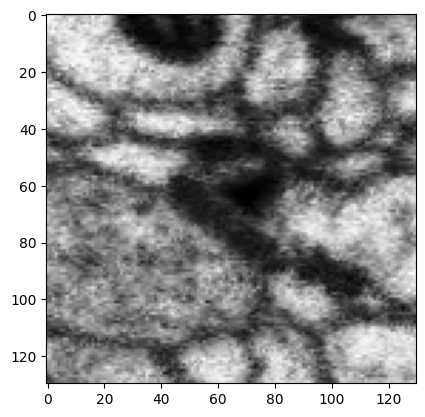

In [33]:
with h5py.File(all_data[354][0], 'r') as f:
    image = f['volumes/raw'][:][:,:,65]
    arr = np.asarray(image)
    plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
    plt.show()


In [10]:
latent = []
label = []

batch_size = 36
z_step = 1

print(f"Processing {len(all_data)} files...")

z_ranges = [20,21]
label_list = []

for image_path, label in tqdm(all_data, desc='File', leave=False):
    try:
        with h5py.File(image_path, 'r') as f:
            image = f['volumes/raw'][:]
            
            z_range = range(z_ranges[0], z_ranges[1], z_step)
            
            for j, z_idx in enumerate(z_range):
                img_batch = []
                
                img = image[:, :, z_idx]
                img_rgb = np.stack([img, img, img], axis=2)
                img_tensor = transform(img_rgb).unsqueeze(0)
                img_batch.append(img_tensor)
                
                # Process batch
                if len(img_batch) == batch_size or j == len(z_range) - 1:
                    if img_batch:
                        batch_tensor = torch.cat(img_batch, dim=0)
                        with torch.no_grad():
                            batch_tensor.to(device)
                            features = model(batch_tensor)
                            latent.append(features)
                            label_list.append(label)
                        img_batch = []
    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")
        continue
print('Done')

Processing 3600 files...


KeyboardInterrupt: 

In [9]:
if latent:
    all_features = torch.cat(latent, dim=0).numpy()

    pca = PCA(n_components=25)
    reduced_features = pca.fit_transform(all_features)
    

    n_neighbor=5
    min_dist=0.01
    n_components=2
    metric='cosine' #cosine
    random_state=10
    
    reducer = umap.UMAP(
        n_neighbors=n_neighbor,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric,
        random_state=random_state
    )
    embedding = reducer.fit_transform(reduced_features)
    
    fig = px.scatter(
        x=embedding[:, 0],
        y=embedding[:, 1],
        color = label_list,
        title = f'UMAP with n_neighbors={n_neighbor}, min_dist={min_dist}, n_components={n_components}, metric={metric},random_state={random_state}',
        width=1500,
        height=1000
    )
    fig.show()
else:
    print("No features were extracted!")
    
    
knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=6)
neigh = knn.fit(embedding[:, 0].reshape(-1,1), embedding[:, 1].reshape(-1,1))

/opt/anaconda3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/opt/anaconda3/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



/opt/anaconda3/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



ValueError: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.

In [2]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() 
                       else 'mps' if torch.backends.mps.is_available() 
                       else "cpu")
        

In [4]:
type(device)

torch.device